# Laboratory 5 instruction part 2 - MLflow

In machine learning development, one of the most challenging aspects is maintaining reproducibility. This issue is particularly relevant to the experimental phase, when a lot of small, but influential code changes are constantly introduced.

After extensive experimentation with different model architectures, hyperparameters, and preprocessing techniques, researchers often find themselves unable to recreate their best-performing models because critical configuration details were not properly recorded.

## MLflow

[MLflow is an open-source platform](https://mlflow.org/) that addresses this challenge by providing systematic experiment tracking throughout the machine learning lifecycle. It automatically captures configurations, metrics, and artifacts from each model training run, transforming ad-hoc model development into a structured, reproducible process. In this notebook, we will learn how to use MLflow to properly track experiments for both traditional machine learning and deep learning workflows.

### Learning objectives

1. **Implement automated experiment tracking** using MLflow autologging capabilities with scikit-learn, enabling automatic capture of model parameters and metrics without writing additional tracking code.

2. **Configure manual logging strategies** for PyTorch experiments, implementing custom tracking for metrics, parameters, and artifacts throughout the training process.

3. **Analyze and compare experimental results** using MLflow tracking UI and programmatic APIs to identify optimal model configurations and understand performance patterns.

### Laboratory plan

1. **MLflow tracking server** configuration and deployment for experiment management
2. **Automatic logging mechanisms** for scikit-learn experiments
3. **Manual logging implementation** for PyTorch deep learning workflows
4. **Hyperparameter optimization exercise** - systematic hyperparameter exploration
5. **Best practices** for experiment organization, versioning, and cross-team reproducibility

## 1. MLflow Tracking server configuration

[MLflow Tracking](https://mlflow.org/docs/latest/tracking/) is the main component of MLflow, responsible for capturing, storing, and presenting metrics, logs, and other tracking data. MLflow is based on a client-server architecture, where the central MLflow server can serve potentially whole teams of data scientists. You can also simply run it as a local server from the commandline, as we will now.

1. Create a directory for MLflow artifacts storage:
```bash
mkdir mlflow-artifacts
```

2. Start the MLflow tracking server:
```bash
mlflow server \
  --backend-store-uri sqlite:///mlflow.db \
  --default-artifact-root ./mlflow-artifacts \
  --host 0.0.0.0 \
  --port 5000
```
Important: Keep this terminal window open. The MLflow server will continue running and be accessible at http://localhost:5000

To verify if the server runs properly, let's connect to git:

In [1]:
import mlflow
import mlflow.sklearn

import warnings

warnings.filterwarnings("ignore")

mlflow.set_tracking_uri("http://localhost:5000")
print(f"Connected to MLflow at: {mlflow.get_tracking_uri()}")

Connected to MLflow at: http://localhost:5000


Setup complete! You now have the MLflow server running as a separate process, and `mlflow` library in this Jupyter Notebook is connected to it. Just note that we had to use the proper host and port - if you want to connect to a remote server, modify the tracking URI appropriately.

## 2. Automatic logging with scikit-learn

### 2.1 Dataset preparation

In this section, we'll use the Ames Housing dataset to demonstrate MLflow's autologging capabilities with scikit-learn. Since we have already prepared the 2006-2008 data using DVC, we can use our preprocessed dataset here. As we have temporal data, the best way to evaluate our model is time (chronological) split, where the newest data is used for testing. We will assume that we have the data for years 2006 and 2007, and evaluate using data from 2008.

In [2]:
import numpy as np
import pandas as pd

from feature_engine.encoding import RareLabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [14]:
df = pd.read_parquet("data/ames_data_2006_2008.parquet")

df = df.sort_values(by=["YrSold"])

df_train = df[df["YrSold"] < 2008]
df_test = df[df["YrSold"] == 2008]

y_train = df_train.pop("SalePrice")
y_test = df_test.pop("SalePrice")

categorical_features = df_train.select_dtypes(include="object").columns
numerical_features = df_train.select_dtypes(exclude="object").columns

In [15]:
median_imputer = SimpleImputer(strategy="median")
min_max_scaler = MinMaxScaler()
rare_encoder = RareLabelEncoder(tol=0.01, n_categories=0)
one_hot_encoder = OneHotEncoder(
    drop="first", sparse_output=False, handle_unknown="ignore"
)

num_pipeline = Pipeline(
    [("median_imputer", median_imputer), ("min_max_scaler", min_max_scaler)]
)

cat_pipeline = Pipeline(
    [("rare_encoder", rare_encoder), ("one_hot_encoder", one_hot_encoder)]
)

column_transformer = ColumnTransformer(
    [
        ("num_pipeline", num_pipeline, numerical_features),
        ("cat_pipeline", cat_pipeline, categorical_features),
    ],
    verbose_feature_names_out=False,
)
column_transformer.fit(df_train)

X_train = column_transformer.transform(df_train)
X_test = column_transformer.transform(df_test)

In [16]:
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

Training samples: 1312
Test samples: 621
Number of features: 181


### 2.2 Training with MLflow autologging

Autologging is a powerful built-in capability of MLflow, enabling fully automated and near-zero code integration of MLflow with many popular frameworks. In particular, it works really well with scikit-learn, thanks to its highly unified API. Let's try this out - we will enable autologging, and then train a buch of different models.

In [17]:
mlflow.sklearn.autolog(
    log_input_examples=True, log_model_signatures=True, log_models=False, silent=False
)

mlflow.set_experiment("ames-housing-autolog")

2025/11/04 08:34:29 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.6.1, but the installed version is 1.7.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2025/11/04 08:34:48 INFO mlflow.tracking.fluent: Experiment with name 'ames-housing-autolog' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/looxx/Desktop/studia/mlops/MLOps-lab5/mlflow-artifacts/1', creation_time=1762241688472, experiment_id='1', last_update_time=1762241688472, lifecycle_stage='active', name='ames-housing-autolog', tags={}>

In [18]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor


models = [
    ("Ridge Regression", Ridge()),
    ("Decision Tree", DecisionTreeRegressor(max_depth=10, random_state=42)),
    ("K-Nearest Neighbors", KNeighborsRegressor(n_neighbors=10)),
    ("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42)),
    ("Gradient Boosting", GradientBoostingRegressor(n_estimators=100, random_state=42)),
]

In [19]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score


def fit_sklearn_models_with_cv(models, X_train, X_test, y_train, y_test):
    results = {}

    for model_name, model in models:
        # start MLflow run - a unit grouping logs from different model runs
        # everything within this context manager will get logged as a run
        with mlflow.start_run(run_name=model_name):
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)

            rmse = root_mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="r2")
            cv_mean = cv_scores.mean()
            cv_std = cv_scores.std()
            
            # log additional custom metrics, in addition to autologging
            mlflow.log_metric("cv_r2_mean", cv_mean)
            mlflow.log_metric("cv_r2_std", cv_std)

            results[model_name] = {
                "rmse": rmse,
                "mae": mae,
                "r2": r2,
                "cv_r2_mean": cv_mean,
            }

            print(f"\n{model_name}:")
            print(f"  RMSE: {rmse:.2f}")
            print(f"  MAE: {mae:.2f}")
            print(f"  R^2: {r2:.3f}")
            print(f"  CV R^2 (mean ± std): {cv_mean:.3f} ± {cv_std:.3f}")


In [20]:
fit_sklearn_models_with_cv(models, X_train, X_test, y_train, y_test)

2025/11/04 08:35:00 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:35:01 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:35:01 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:35:01 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:35:01 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:35:01 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:35:01 WARNING mlflow.sklearn: Failed t


Ridge Regression:
  RMSE: 23450.39
  MAE: 16430.79
  R^2: 0.904
  CV R^2 (mean ± std): 0.880 ± 0.037
🏃 View run Ridge Regression at: http://localhost:5000/#/experiments/1/runs/669bb9316c074b61b29526861dcf6e2f
🧪 View experiment at: http://localhost:5000/#/experiments/1


2025/11/04 08:35:01 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:35:02 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:35:02 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:35:02 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:35:02 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:35:02 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'



Decision Tree:
  RMSE: 36860.51
  MAE: 23270.66
  R^2: 0.762
  CV R^2 (mean ± std): 0.726 ± 0.080
🏃 View run Decision Tree at: http://localhost:5000/#/experiments/1/runs/fefb78e5b6184337aba4554870106ed1
🧪 View experiment at: http://localhost:5000/#/experiments/1


  File "c:\Users\looxx\Desktop\studia\mlops\MLOps-lab5\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\looxx\Desktop\studia\mlops\MLOps-lab5\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\looxx\AppData\Roaming\uv\python\cpython-3.11.13-windows-x86_64-none\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\looxx\AppData\Roaming\uv\python\cpython-3.11.13-windows-x86_64-none\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\looxx\AppData\Roaming\uv\python\cpython-3.11.13-windows-x86_64-none\Lib\subprocess.py", li


K-Nearest Neighbors:
  RMSE: 38325.06
  MAE: 26034.07
  R^2: 0.743
  CV R^2 (mean ± std): 0.656 ± 0.050
🏃 View run K-Nearest Neighbors at: http://localhost:5000/#/experiments/1/runs/87e2e3bb8ed945abaf3fed45e6e87ab4
🧪 View experiment at: http://localhost:5000/#/experiments/1


2025/11/04 08:35:07 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:35:09 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:35:11 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:35:14 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:35:16 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:35:18 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'



Random Forest:
  RMSE: 25896.23
  MAE: 15509.71
  R^2: 0.883
  CV R^2 (mean ± std): 0.870 ± 0.043
🏃 View run Random Forest at: http://localhost:5000/#/experiments/1/runs/ba534e6438504eeda275edd3534f7422
🧪 View experiment at: http://localhost:5000/#/experiments/1


2025/11/04 08:35:20 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:35:20 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:35:21 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:35:22 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:35:23 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'



Gradient Boosting:
  RMSE: 21572.13
  MAE: 13809.38
  R^2: 0.919
  CV R^2 (mean ± std): 0.898 ± 0.031
🏃 View run Gradient Boosting at: http://localhost:5000/#/experiments/1/runs/40444ec1e00d449b92009f5037142a97
🧪 View experiment at: http://localhost:5000/#/experiments/1


Open the MLflow dashboard at http://localhost:5000/ and go to the Experiments tab. On the left, you have the experiment name, and when you select it, the list of all experiments will show up. Click through the interface and familiarize yourself with the most important elements:

1. What columns can be selected
2. Pick a particular run and check what values are logged automatically
3. Select columns to compare a given metric between runs, e.g. MAE
4. Sort algorithms by the selected metric to pick the best one

### Exercise 1

We have trained 5 different models. The results of all of them can now be compared in MLflow. Since we obtained quite satisfactory results, our imaginary client would like to be sure that we do our best and wants us to compare many more combinations.

Your task is to run 5 more experiments with different parameters and models from scikit-learn. You can use any [supervised learning methods from scikit-learn](https://scikit-learn.org/stable/supervised_learning.html). Find some other models or parameters to tune our current models with and run the experiments again. Use the function `fit_sklearn_models_with_cv()` created above, or you can write your own if you want.

Did you manage to beat the previous approaches?

In [21]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor
from sklearn.tree import ExtraTreeRegressor

additional_models = [
    ("Linear Regression", LinearRegression()),
    ("Support Vector Regressor", SVR(kernel='rbf')),
    ("Extra Trees", ExtraTreesRegressor(n_estimators=100, random_state=42)),
    ("AdaBoost", AdaBoostRegressor(n_estimators=100, random_state=42)),
    ("Extra Tree", ExtraTreeRegressor(random_state=42)),
]

fit_sklearn_models_with_cv(additional_models, X_train, X_test, y_train, y_test)

2025/11/04 08:36:09 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:36:12 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:36:12 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:36:12 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:36:12 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:36:12 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:36:12 WARNING mlflow.sklearn: Failed t


Linear Regression:
  RMSE: 24060.43
  MAE: 16741.64
  R^2: 0.899
  CV R^2 (mean ± std): 0.856 ± 0.054
🏃 View run Linear Regression at: http://localhost:5000/#/experiments/1/runs/ebf7a2914308465d878458b1d5021331
🧪 View experiment at: http://localhost:5000/#/experiments/1


2025/11/04 08:36:13 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:36:14 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:36:14 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:36:15 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:36:15 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:36:16 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'



Support Vector Regressor:
  RMSE: 77482.01
  MAE: 54914.40
  R^2: -0.051
  CV R^2 (mean ± std): -0.129 ± 0.135
🏃 View run Support Vector Regressor at: http://localhost:5000/#/experiments/1/runs/18a07280eb904c8e94590f51c8c1de00
🧪 View experiment at: http://localhost:5000/#/experiments/1


2025/11/04 08:36:19 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:36:21 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:36:24 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:36:26 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:36:28 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:36:30 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'



Extra Trees:
  RMSE: 23448.54
  MAE: 14918.67
  R^2: 0.904
  CV R^2 (mean ± std): 0.873 ± 0.044
🏃 View run Extra Trees at: http://localhost:5000/#/experiments/1/runs/0b4ce1ec5a2044b7b3298c2fb57b1a6e
🧪 View experiment at: http://localhost:5000/#/experiments/1


2025/11/04 08:36:31 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:36:32 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:36:33 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:36:34 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:36:35 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:36:36 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'



AdaBoost:
  RMSE: 31826.35
  MAE: 23057.82
  R^2: 0.823
  CV R^2 (mean ± std): 0.803 ± 0.077
🏃 View run AdaBoost at: http://localhost:5000/#/experiments/1/runs/a01394abc290461da8b2a420bdd13cac
🧪 View experiment at: http://localhost:5000/#/experiments/1


2025/11/04 08:36:36 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:36:36 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:36:36 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:36:36 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/04 08:36:36 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'



Extra Tree:
  RMSE: 42058.30
  MAE: 26836.40
  R^2: 0.690
  CV R^2 (mean ± std): 0.722 ± 0.105
🏃 View run Extra Tree at: http://localhost:5000/#/experiments/1/runs/95a977ab99a7496fa7cc737300eb9a34
🧪 View experiment at: http://localhost:5000/#/experiments/1


## 3. Manual logging with PyTorch

In this section, we'll implement manual logging for PyTorch models. While scikit-learn has autologging, PyTorch requires manual tracking - giving us full control over what and when to log. MLflow supports autologging for [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/), but many people prefer or often need low-level control of pure PyTorch. Thus, we will focus on this approach, which also will teach us more about powerful MLflow capabilities.

Note that we need to turn off scikit-learn autologging! Since we are using a Jupyter Notebook, MLflow uses the previously configured autologging unless explicitly turned off.

In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold

# disable sklearn autologging!
mlflow.sklearn.autolog(disable=True)

mlflow.set_experiment("pytorch-housing-manual")

2025/11/04 08:37:50 INFO mlflow.tracking.fluent: Experiment with name 'pytorch-housing-manual' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/looxx/Desktop/studia/mlops/MLOps-lab5/mlflow-artifacts/2', creation_time=1762241870611, experiment_id='2', last_update_time=1762241870611, lifecycle_stage='active', name='pytorch-housing-manual', tags={}>

### 3.1 Targets transformation

Before training the neural network, we will transform the training target, in order to stabilize the training. To see why, let's plot the house prices:

<Axes: ylabel='Frequency'>

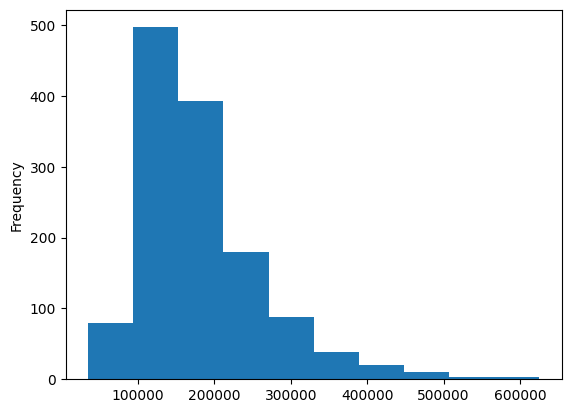

In [23]:
y_train.plot.hist()

Training on such targets is possible, but very large target values easily risk overflow, particularly when a loss function like mean squared error is used. We will use the log-transform to transform this distribution, as it's near-exponential, so it should bring it closer to normal, and also greatly reduce the values range.

Of course, we will need to transform the network predictions back again to evaluate them!

<Axes: ylabel='Frequency'>

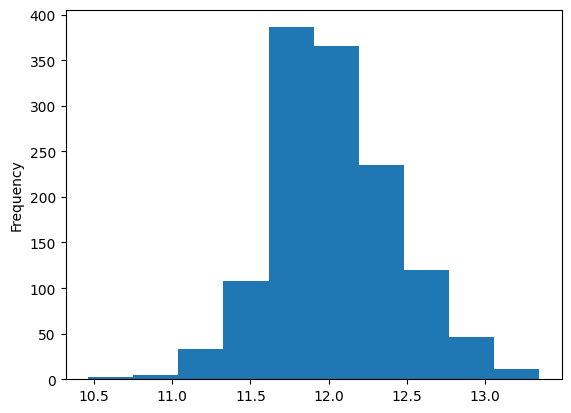

In [24]:
y_train_log = np.log1p(y_train)

pd.Series(y_train_log).plot.hist()

### 3.2 Define and train the model

Since we have tabular data, we will use a simple 2-layer multilayer perceptron (MLP).

In [25]:
class HousePriceNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout_rate=0.2):
        super(HousePriceNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


For training, we will check both the 5-fold CV performance, and the traditional train-test split. Cross-validation will give us an additional, robust performance estimation, as well as standard deviation, which is useful for comparing performances of different models. After all, if the difference between models would be within one standard deviation, it wouldn't really be meaningful.

In [26]:
import torch.nn as nn


class PyTorchTrainer:
    def __init__(
        self, model_class: type[nn.Module], config: dict
    ):
        self.model_class = model_class
        self.config = config

    def create_model(self, input_dim: int) -> nn.Module:
        return self.model_class(
            input_dim=input_dim,
            hidden_dim=self.config["hidden_units"],
            dropout_rate=self.config["dropout"],
        )

    def create_data_loader(
        self, X: torch.Tensor, y: torch.Tensor, shuffle: bool = True
    ) -> DataLoader:
        dataset = TensorDataset(X, y)
        return DataLoader(
            dataset, batch_size=self.config["batch_size"], shuffle=shuffle
        )

    def train_epoch(
        self,
        model: nn.Module,
        train_loader: DataLoader,
        criterion: nn.Module,
        optimizer: optim.Optimizer,
    ) -> float:
        model.train()
        epoch_loss = 0.0
        batch_count = 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            batch_count += 1

        return epoch_loss / batch_count

    def train_model(
        self,
        model: nn.Module,
        train_loader: DataLoader,
        epochs: int,
        metric_prefix: str = "",
    ) -> None:
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=self.config["learning_rate"])

        for epoch in range(epochs):
            avg_mse = self.train_epoch(model, train_loader, criterion, optimizer)

            if epoch % self.config["log_interval"] == 0:
                metric_name = (
                    f"{metric_prefix}train_mse" if metric_prefix else "train_mse"
                )
                # manually log metric value, with a given name and step value
                mlflow.log_metric(metric_name, avg_mse, step=epoch)

    @torch.no_grad()
    def evaluate_model(
        self,
        model: nn.Module,
        X: torch.Tensor,
        y_test: torch.Tensor,
        log_prefix: str = "",
    ) -> dict[str, float]:
        model.eval()
        
        y_pred_norm = model(X)

        # revert the logarithm with exponent
        y_pred = np.expm1(y_pred_norm.numpy())
        y_test = y_test.numpy()

        rmse = root_mean_squared_error(y_test.ravel(), y_pred.ravel())
        mae = mean_absolute_error(y_test.ravel(), y_pred.ravel())
        r2 = r2_score(y_test.ravel(), y_pred.ravel())

        if log_prefix:
            # manually log metrics that we want
            mlflow.log_metric(f"{log_prefix}_rmse", rmse)
            mlflow.log_metric(f"{log_prefix}_mae", mae)
            mlflow.log_metric(f"{log_prefix}_r2", r2)

        return {"rmse": rmse, "mae": mae, "r2": r2}

    def run_cross_validation(
        self, X_train: torch.Tensor, y_train: torch.Tensor, n_splits: int = 5
    ) -> tuple[float, float, list[float]]:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        cv_scores = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
            print(f"\nTraining Fold {fold + 1}/{n_splits}...")

            X_fold_train = X_train[train_idx]
            y_fold_train = y_train[train_idx]
            X_fold_val = X_train[val_idx]
            y_fold_val = y_train[val_idx]

            fold_model = self.create_model(X_train.shape[1])
            fold_loader = self.create_data_loader(X_fold_train, y_fold_train)

            self.train_model(
                fold_model,
                fold_loader,
                self.config["epochs"],
                metric_prefix=f"fold_{fold + 1}_",
            )

            # transform validation data with exponent back to original unit
            y_fold_val = np.expm1(y_fold_val)
            
            val_metrics = self.evaluate_model(
                fold_model, X_fold_val, y_fold_val, log_prefix=f"fold_{fold + 1}_val"
            )

            cv_scores.append(val_metrics["r2"])
            print(
                f"  Fold {fold + 1} "
                f"Validation - RMSE: {val_metrics['rmse']:.2f}, "
                f"MAE: {val_metrics['mae']:.2f} "
                f"R^2: {val_metrics['r2']:.3f}"
            )

        return np.mean(cv_scores), np.std(cv_scores), cv_scores

    def fit(
        self,
        X_train: pd.DataFrame | np.ndarray,
        y_train: pd.Series | np.ndarray,
        X_test: pd.DataFrame | np.ndarray,
        y_test: pd.Series | np.ndarray,
    ) -> dict:
        X_train, X_test, y_train, y_test = self._prepare_tensors(
            X_train, X_test, y_train, y_test
        )

        with mlflow.start_run(run_name=self.config["name"]):
            mlflow.log_params(self.config)

            print(f"Starting 5-fold cross-validation for {self.config['name']}...")
            cv_mean, cv_std, cv_scores = self.run_cross_validation(X_train, y_train)

            mlflow.log_metric("cv_r2_mean", cv_mean)
            mlflow.log_metric("cv_r2_std", cv_std)

            print(
                f"\nCross-validation complete. Mean R^2: {cv_mean:.3f} (+/- {cv_std:.3f})"
            )
            print("\nTraining final model on all training data...")

            final_model = self.create_model(X_train.shape[1])
            final_loader = self.create_data_loader(X_train, y_train)

            self.train_model(
                final_model,
                final_loader,
                self.config["epochs"],
                metric_prefix="final_model_",
            )

            print("\nEvaluating on test set...")
            test_metrics = self.evaluate_model(final_model, X_test, y_test)

            mlflow.log_metric("test_rmse", test_metrics["rmse"])
            mlflow.log_metric("test_mae", test_metrics["mae"])
            mlflow.log_metric("test_r2", test_metrics["r2"])

            self._print_results(test_metrics, cv_mean, cv_std)

            return {
                "rmse": test_metrics["rmse"],
                "mae": test_metrics["mae"],
                "r2": test_metrics["r2"],
                "cv_r2_mean": cv_mean,
                "cv_r2_std": cv_std,
                "cv_scores": cv_scores,
            }

    def _prepare_tensors(self, X_train, X_test, y_train, y_test) -> tuple:
        y_train = np.array(y_train)
        y_test = np.array(y_test)
        
        X_train_tensor = torch.FloatTensor(X_train)
        y_train_tensor = torch.FloatTensor(y_train.reshape(-1, 1))
        
        X_test_tensor = torch.FloatTensor(X_test)
        y_test_tensor = torch.FloatTensor(y_test.reshape(-1, 1))

        print(f"Training samples: {X_train_tensor.shape[0]}")
        print(f"Input features: {X_train_tensor.shape[1]}")
        
        return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor
    
    def _print_results(
        self, test_metrics: dict[str, float], cv_mean: float, cv_std: float
    ) -> None:
        print(f"{'=' * 50}\n")
        print(f"  Mean R^2: {cv_mean:.3f} (+/- {cv_std:.3f})")
        print("\nCross-Validation Performance:")
        print(f"  R^2: {test_metrics['r2']:.3f}")
        print(f"  RMSE: {test_metrics['rmse']:.2f}")
        print(f"  MAE: {test_metrics['mae']:.2f}")
        print("Test Set Performance:")
        print(f"{'=' * 50}")
        print(f"FINAL RESULTS for {self.config['name']}:")
        print(f"\n{'=' * 50}")


Quite a bit of code there! So now let's train the model.

In [27]:
base_config = {
    "model_class": HousePriceNet,
    "random_seed": 42,
    "log_interval": 5,
    "num_samples": X_train.shape[0],
    "input_features": X_train.shape[1],
    "k_folds": 5,
}

config = {
    "name": "first_run",
    "hidden_units": 128,
    "dropout": 0.1,
    "learning_rate": 0.03,
    "epochs": 150,
    "batch_size": 32,
}

In [28]:
training_config = base_config | config

trainer = PyTorchTrainer(training_config["model_class"], training_config)
results = trainer.fit(X_train, y_train_log, X_test, y_test)

Training samples: 1312
Input features: 181
Starting 5-fold cross-validation for first_run...

Training Fold 1/5...
  Fold 1 Validation - RMSE: 41596.40, MAE: 33119.34 R^2: 0.719

Training Fold 2/5...
  Fold 2 Validation - RMSE: 23341.50, MAE: 17374.71 R^2: 0.908

Training Fold 3/5...
  Fold 3 Validation - RMSE: 45829.97, MAE: 36480.22 R^2: 0.704

Training Fold 4/5...
  Fold 4 Validation - RMSE: 26310.38, MAE: 18223.82 R^2: 0.885

Training Fold 5/5...
  Fold 5 Validation - RMSE: 32443.58, MAE: 21964.27 R^2: 0.836

Cross-validation complete. Mean R^2: 0.810 (+/- 0.084)

Training final model on all training data...

Evaluating on test set...

  Mean R^2: 0.810 (+/- 0.084)

Cross-Validation Performance:
  R^2: 0.900
  RMSE: 23890.58
  MAE: 16740.90
Test Set Performance:
FINAL RESULTS for first_run:

🏃 View run first_run at: http://localhost:5000/#/experiments/2/runs/b3adcb1d07d34f79a40e64d24087956b
🧪 View experiment at: http://localhost:5000/#/experiments/2


Go to the MLflow dashboard and take a look at logged values. Focus particularly on the "Model metrics" tab, which for neural networks visualizes the progress of iterative training.

### 3.3 Hyperparameter optimization with MLflow

Now, we will use MLflow logging and visualization capabilities to help us tune hyperparameters of neural networks. This is one of the major applications of experiment tracking frameworks. As neural networks have many hyperparameters, with complex interactions, and training them many times is very computationally intensive, we want to use human judgment, based on plots and metrics, to guide our choices in further experiments.

A quick recap on main hyperparameters of MLPs:

1. **Learning rate:**
   - typically 1e-5 to 1e-1
   - too high: loss explodes, model diverges
   - too low: slow convergence, might get stuck
   - sweet spot: fast convergence to good minimum

3. **Model size** - number of hidden units here:
   - typically 32 to 512
   - too few: underfitting, can't capture patterns
   - too many: overfitting, slow training, diminishing returns
   - consider: more features need more capacity

5. **Dropout rate:**
   - typically 0.0 to 0.5
   - 0.0: no regularization, risk overfitting
   - too high: underfitting, loses important information
   - purpose: prevents over-reliance on specific neurons

7. **Batch size:**
   - typically 16 to 128
   - small: noisy gradients, often better generalization, slower
   - large: stable gradients, faster training, needs more memory, may overfit
   - trade-off: speed vs generalization

9. **Number of epochs:**
   - too few: underfitting
   - too many: overfitting
   - optimal: when validation loss stops improving
   - watch validation loss


### Exercise 2

Your task is to:
1. Run 10 experiments by modifying the hyperparameter configuration. Try to improve model performance, which is currently overfitted.
2. Analyze results in MLflow UI.
3. Comment on what changes impacted the model performance the most, and what changes disrupted the training process.
4. Compare the results of our first scikit-learn configuration with the first PyTorch experiments. Do you see any overfitting in the first PyTorch experiment? Explain what signs of overfitting can indicate this situation.

Example:

```python

base_config = {
    # or any other your own architecture :) we definitely recommend to experiment by yourselves
    "model_class": HousePriceNet,
    "random_seed": 42,
    "log_interval": 5,
    "input_features": X_train.shape[1],
    "num_samples": X_train.shape[0],
    "target_normalized": True,
    "k_folds": 5,
}

configs = {
     {
        "name": "first_run_or_other_your_own_meaningful_name",
        "hidden_units": 128,
         ...
     },
    {
        "name": "second_run_or...",
        "hidden_units": 128,
        "dropout": 0.1,
        "learning_rate": 0.03,
        "epochs": 150,
        "batch_size": 32,    
    }
}

for config in configs:
    # in python we can in elegant way merge two dicts using "|" operator - finally...
    # old merging method {**base_config, **config} - ugly :(
    training_config = base_config | config 
    trainer = PyTorchTrainer(training_config["model_class"], preprocessor, training_config)
    results = trainer.fit(X_train, y_train, X_test, y_test)
```

or just manually and incrementally:

```python
new_config = {
    "name": "second_run_or...",
    "hidden_units": 128,
    "dropout": 0.1,
    "learning_rate": 0.03,
    "epochs": 150,
    "batch_size": 32,    
}

training_config = base_config | config 
trainer = PyTorchTrainer(training_config["model_class"], preprocessor, training_config)
results = trainer.fit(X_train, y_train, X_test, y_test)
```

In [29]:
base_config = {
    "model_class": HousePriceNet,
    "random_seed": 42,
    "log_interval": 5,
    "num_samples": X_train.shape[0],
    "input_features": X_train.shape[1],
    "k_folds": 5,
}

configs = [
    {
        "name": "exp1_lr_low",
        "hidden_units": 128,
        "dropout": 0.1,
        "learning_rate": 0.001,
        "epochs": 150,
        "batch_size": 32,
    },
    {
        "name": "exp2_lr_high",
        "hidden_units": 128,
        "dropout": 0.1,
        "learning_rate": 0.1,
        "epochs": 150,
        "batch_size": 32,
    },
    {
        "name": "exp3_hidden_large",
        "hidden_units": 256,
        "dropout": 0.1,
        "learning_rate": 0.03,
        "epochs": 150,
        "batch_size": 32,
    },
    {
        "name": "exp4_hidden_small",
        "hidden_units": 64,
        "dropout": 0.1,
        "learning_rate": 0.03,
        "epochs": 150,
        "batch_size": 32,
    },
    {
        "name": "exp5_dropout_high",
        "hidden_units": 128,
        "dropout": 0.3,
        "learning_rate": 0.03,
        "epochs": 150,
        "batch_size": 32,
    },
    {
        "name": "exp6_dropout_low",
        "hidden_units": 128,
        "dropout": 0.05,
        "learning_rate": 0.03,
        "epochs": 150,
        "batch_size": 32,
    },
    {
        "name": "exp7_batch_small",
        "hidden_units": 128,
        "dropout": 0.1,
        "learning_rate": 0.03,
        "epochs": 150,
        "batch_size": 16,
    },
    {
        "name": "exp8_batch_large",
        "hidden_units": 128,
        "dropout": 0.1,
        "learning_rate": 0.03,
        "epochs": 150,
        "batch_size": 64,
    },
    {
        "name": "exp9_epochs_more",
        "hidden_units": 128,
        "dropout": 0.1,
        "learning_rate": 0.03,
        "epochs": 200,
        "batch_size": 32,
    },
    {
        "name": "exp10_epochs_less",
        "hidden_units": 128,
        "dropout": 0.1,
        "learning_rate": 0.03,
        "epochs": 100,
        "batch_size": 32,
    },
]

for config in configs:
    training_config = base_config | config
    trainer = PyTorchTrainer(training_config["model_class"], training_config)
    results = trainer.fit(X_train, y_train_log, X_test, y_test)

Training samples: 1312
Input features: 181
Starting 5-fold cross-validation for exp1_lr_low...

Training Fold 1/5...
  Fold 1 Validation - RMSE: 86764.69, MAE: 39951.43 R^2: -0.223

Training Fold 2/5...
  Fold 2 Validation - RMSE: 53802.25, MAE: 36813.36 R^2: 0.510

Training Fold 3/5...
  Fold 3 Validation - RMSE: 48525.25, MAE: 34177.91 R^2: 0.668

Training Fold 4/5...
  Fold 4 Validation - RMSE: 73246.86, MAE: 48408.26 R^2: 0.112

Training Fold 5/5...
  Fold 5 Validation - RMSE: 46568.41, MAE: 36958.55 R^2: 0.663

Cross-validation complete. Mean R^2: 0.346 (+/- 0.349)

Training final model on all training data...

Evaluating on test set...

  Mean R^2: 0.346 (+/- 0.349)

Cross-Validation Performance:
  R^2: 0.329
  RMSE: 61932.33
  MAE: 42607.28
Test Set Performance:
FINAL RESULTS for exp1_lr_low:

🏃 View run exp1_lr_low at: http://localhost:5000/#/experiments/2/runs/b3001ddfc032484f9d920e0cb3f5ba46
🧪 View experiment at: http://localhost:5000/#/experiments/2
Training samples: 1312
In

## Analysis of Exercise 2 Results

![MLflow Results](output.png)

So I ran the 10 experiments and here's what happened:

**What broke stuff:**
- Learning rate at 0.001 was way too slow
- Batch size 64 is certainly too big

**What kind of worked:**
- More dropout seem to yield better results
- More epochs gave improvement, less epochs was a bit worse